In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
import pandas_profiling

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics
import statsmodels.formula.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [20]:
data = pd.read_csv("House_Prices.csv")
data.drop(columns = ["Home"], inplace = True)
data.head()


,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,114300,1790,2,2,2,No,East
1,114200,2030,4,2,3,No,East
2,114800,1740,3,2,1,No,East
3,94700,1980,3,2,3,No,East
4,119800,2130,3,3,3,No,East


In [21]:
numeric_var_names = [key for key, val in dict(data.dtypes).items() if val in ["float64","int64","float32","int32"]]
cat_var_names = [key for key, val in dict(data.dtypes).items() if val in ["object"]]
print(numeric_var_names)
print(cat_var_names)

['Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
['Brick', 'Neighborhood']


In [22]:
data_num = data[numeric_var_names]
data_cat = data[cat_var_names]

In [25]:
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x
data_num = data_num.apply(outlier_capping)
data_num.head()

,Price,SqFt,Bedrooms,Bathrooms,Offers
0,114300.0,1790.0,2.0,2.0,2.0
1,114200.0,2030.0,4.0,2.0,3.0
2,114800.0,1740.0,3.0,2.0,1.0
3,94700.0,1980.0,3.0,2.0,3.0
4,119800.0,2130.0,3.0,3.0,3.0


In [37]:
data[data.isna().any(axis=1)]

,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood


Since there are no missing values. Hence there is no need for handling imputation

In [40]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1 )
    df.drop(colname, axis = 1, inplace = True)
    return df

for c_feature in data_cat.columns:
    data_cat[c_feature] = data_cat[c_feature].astype("category")
    data_cat = create_dummies(data_cat, c_feature)
data_cat.head()

,Brick_Yes,Neighborhood_North,Neighborhood_West
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [41]:
data_new = pd.concat([data_num, data_cat], axis = 1)
data_new.head()

,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West
0,114300.0,1790.0,2.0,2.0,2.0,0,0,0
1,114200.0,2030.0,4.0,2.0,3.0,0,0,0
2,114800.0,1740.0,3.0,2.0,1.0,0,0,0
3,94700.0,1980.0,3.0,2.0,3.0,0,0,0
4,119800.0,2130.0,3.0,3.0,3.0,0,0,0


Check whether Price is following normal distribution

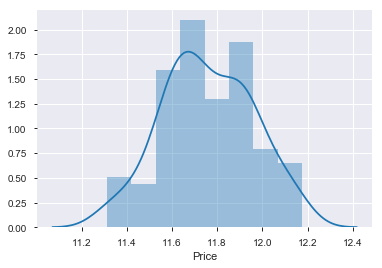

In [43]:
sns.distplot(np.log(data_new.Price))
plt.show()

In [61]:
features = data_new[data_new.columns.difference(["Price"])]
target = data_new["Price"]

In [62]:
features.columns

Index(['Bathrooms', 'Bedrooms', 'Brick_Yes', 'Neighborhood_North',
       'Neighborhood_West', 'Offers', 'SqFt'],
      dtype='object')

Now Feature elimination. Removing the features who has no correlation with the Y

### Applying RFE (Recursive Feature Elimination)

In [72]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select = 7)
rfe = rfe.fit(features, target)

In [73]:
for feature, select in zip(features.columns, rfe.get_support()):
    print(feature, select)
    

Bathrooms True
Bedrooms True
Brick_Yes True
Neighborhood_North True
Neighborhood_West True
Offers True
SqFt True


In [74]:
RFE_features = features.columns[rfe.get_support()]
RFE_features

Index(['Bathrooms', 'Bedrooms', 'Brick_Yes', 'Neighborhood_North',
       'Neighborhood_West', 'Offers', 'SqFt'],
      dtype='object')

### F regression

In [75]:
from sklearn.feature_selection import f_regression
F_values, p_values = f_regression(features, target)

In [76]:
f_reg_results = [(i,v,z) for i, v, z in zip(features.columns, F_values, ["%.3f" %p for p in p_values])]
f_reg_results = pd.DataFrame(f_reg_results, columns = ["Variable", "F_Value","P_value"])
f_reg_results

,Variable,F_Value,P_value
0,Bathrooms,42.427728,0.000
1,Bedrooms,47.144784,0.000
2,Brick_Yes,32.411521,0.000
3,Neighborhood_North,55.281491,0.000
4,Neighborhood_West,135.565966,0.000
5,Offers,13.885529,0.000
6,SqFt,54.266618,0.000


Hence all features are important

### VIF

In [77]:
all_columns = "+".join(RFE_features)
my_formula = "Price ~ "+ all_columns
my_formula

'Price ~ Bathrooms+Bedrooms+Brick_Yes+Neighborhood_North+Neighborhood_West+Offers+SqFt'

In [79]:
my_formula = 'Price ~ Bathrooms+Bedrooms+Brick_Yes+Neighborhood_North+\
Neighborhood_West+Offers+SqFt'

In [80]:
y, x = dmatrices(my_formula, data_new, return_type="dataframe")

In [87]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,121.7,Intercept
1,1.5,Bathrooms
2,1.7,Bedrooms
3,1.1,Brick_Yes
4,1.7,Neighborhood_North
5,1.8,Neighborhood_West
6,1.7,Offers
7,1.8,SqFt


### Sampling

In [88]:
train, test = train_test_split(data_new, test_size = 0.3, random_state = 123)
print(len(train))
print(len(test))

89
39


In [92]:
my_formula = 'Price ~ Bathrooms+Bedrooms+Brick_Yes+\
Neighborhood_West+Offers+SqFt'

In [93]:
model = sm.ols(my_formula, data = train)
model = model.fit()

In [94]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     92.69
Date:                Sun, 16 Feb 2020   Prob (F-statistic):           2.01e-34
Time:                        00:29:04   Log-Likelihood:                -939.41
No. Observations:                  89   AIC:                             1893.
Df Residuals:                      82   BIC:                             1910.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1591.1067   1.02e+0

In [95]:
train["pred"] = pd.DataFrame(model.predict(train))
test["pred"] = pd.DataFrame(model.predict(test))

In [96]:
train.head()

,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West,pred
79,143600.0,1780.0,4.0,2.0,1.0,0,0,1,141362.999759
104,82300.0,1910.0,3.0,2.0,4.0,0,0,0,98174.220259
60,180900.0,2200.0,3.0,3.0,1.0,0,0,1,167385.416717
21,113800.0,2000.0,3.0,2.0,4.0,0,1,0,102901.495190
11,123000.0,1870.0,2.0,2.0,2.0,1,0,0,124263.283929


In [97]:
test.head()

,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West,pred
4,119800.0,2130.0,3.0,3.0,3.0,0,0,0,125220.779155
123,119700.0,1900.0,3.0,3.0,3.0,1,0,0,130816.724170
90,143100.0,1920.0,4.0,2.0,2.0,0,0,1,141369.034085
82,164800.0,2050.0,2.0,2.0,1.0,1,0,1,164858.197507
42,105600.0,1990.0,2.0,2.0,3.0,0,0,0,105542.053989


### Accuracy metrics

In [99]:
# Train data
MAPE_train = np.mean(np.abs(train.Price - train.pred)/train.Price)
print(MAPE_train)

RMSE_train = metrics.mean_squared_error(train.Price, train.pred)
print(RMSE_train)

Corr_train = stats.pearsonr(train.Price, train.pred)
print(Corr_train)

# Test 
MAPE_test = np.mean(np.abs(test.Price - test.pred)/test.Price)
print(MAPE_test)

RMSE_test = metrics.mean_squared_error(test.Price, test.pred)
print(RMSE_test)

Corr_test = stats.pearsonr(test.Price, test.pred)
print(Corr_test)

0.061693012998568116
86222120.47722489
(0.9335448777922365, 1.5720954880472956e-40)
0.05548943027138691
97166705.94144826
(0.9277146185620173, 2.048470026341533e-17)


### Decile Analysis

In [100]:
train["Decile"] = pd.qcut(train["pred"], 10, labels = False)
train.head()

,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West,pred,Decile
79,143600.0,1780.0,4.0,2.0,1.0,0,0,1,141362.999759,7
104,82300.0,1910.0,3.0,2.0,4.0,0,0,0,98174.220259,0
60,180900.0,2200.0,3.0,3.0,1.0,0,0,1,167385.416717,9
21,113800.0,2000.0,3.0,2.0,4.0,0,1,0,102901.495190,1
11,123000.0,1870.0,2.0,2.0,2.0,1,0,0,124263.283929,5


In [103]:
avg_actual = train[["Decile", "Price"]].groupby(train.Decile).mean().sort_index(ascending = False)["Price"]
avg_pred = train[["Decile", "pred"]].groupby(train.Decile).mean().sort_index(ascending = False)["pred"]

In [104]:
Decile_analysis_train = pd.concat([avg_actual, avg_pred], axis = 1)

In [105]:
Decile_analysis_train

,Price,pred
Decile,,
9,178059.662222,174497.759054
8,150600.000000,153242.453391
7,141200.000000,142171.332726
6,136244.444444,135981.074661
5,126675.000000,127258.632125
4,122588.888889,119992.976794
3,111188.888889,114085.143788
2,105311.111111,109207.320093
1,102511.111111,100681.997196


# Hence the model is validated